# Finding Similar Book Reviews

This notebook implements a scalable detector of similar book reviews using MinHash and Locality-Sensitive Hashing (LSH), as part of the “Algorithms for Massive Data” course. 

I use 5-character shingles to tokenize the text and MinHash signatures with 64 permutations to obtain compressed representations. LSH is then applied to efficiently identify similar pairs among the reviews.

In [22]:
import html
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import unicodedata
import zipfile
from datasketch import MinHash, MinHashLSH


## 📥 Dataset Setup & Loading

In this section,I prepare the Amazon Books Reviews dataset.  
I check whether the dataset is already available locally; if not,I extract it from the Kaggle-provided zip archive.  
The dataset is then loaded into a pandas DataFrame for further processing.

In [23]:
# Download dataset only if not already present
zip_path = "amazon-books-reviews.zip"
csv_path = os.path.join("data", "Books_rating.csv")

if not os.path.exists(csv_path):
    print("📥 Downloading dataset from Kaggle...")
    kaggle_dir = os.path.expanduser("~/.kaggle")
    os.makedirs(kaggle_dir, exist_ok=True)
    
    if not os.path.exists(os.path.join(kaggle_dir, "kaggle.json")):
        print("Please upload your kaggle.json manually or place it in ~/.kaggle")
    
    os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)
    
    !kaggle datasets download -d mohamedbakhet/amazon-books-reviews
    
    with zipfile.ZipFile("amazon-books-reviews.zip", "r") as zip_ref:
        zip_ref.extractall("data")  # output folder = ./data

csv_path = os.path.join("data", "Books_rating.csv") 
df = pd.read_csv(csv_path)

df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


## Missing Values, Empty Strings, and Short Reviews

In [24]:
missing_count = df["review/text"].isna().sum()
empty_strings = (df["review/text"].fillna("").str.strip() == "").sum()
short_reviews = df["review/text"].fillna("").apply(lambda x: len(str(x).split()) <= 3).sum()

print(f"Number of NaN: {missing_count}")
print(f"Number of Empty string: {empty_strings}")
print(f"Number of very short strings (≤ 3 words): {short_reviews}")

Number of NaN: 8
Number of Empty string: 8
Number of very short strings (≤ 3 words): 864


## Exploratory Data Analysis on Review Lengths

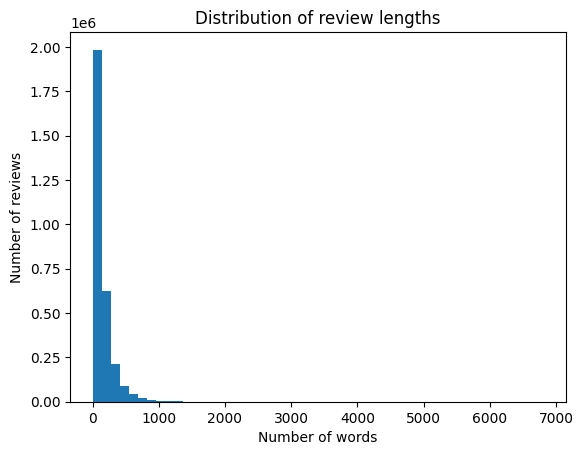

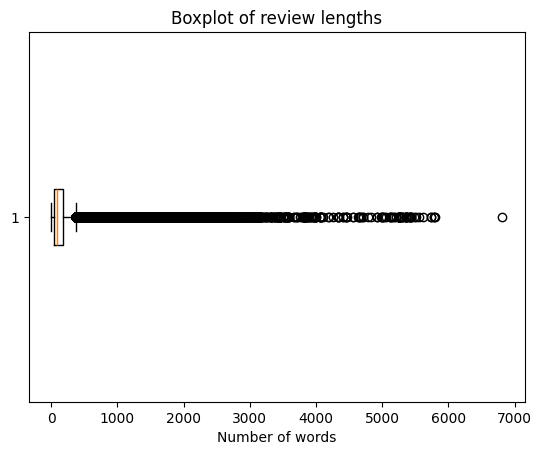

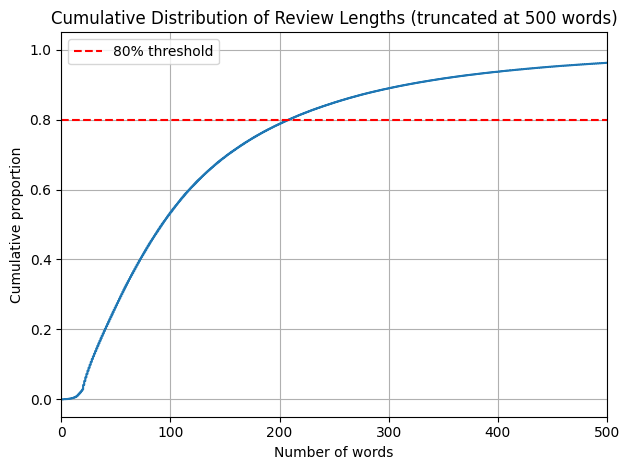

In [25]:
def word_count(text):
    return len(str(text).split())

review_lengths = df["review/text"].dropna().apply(word_count)

plt.hist(review_lengths, bins=50)
plt.xlabel("Number of words")
plt.ylabel("Number of reviews")
plt.title("Distribution of review lengths")

plt.savefig("distribution_of_review_lengths.png", dpi=300, bbox_inches='tight')  # PNG

plt.show()

plt.boxplot(review_lengths, vert=False)
plt.xlabel("Number of words")
plt.title("Boxplot of review lengths")
plt.savefig("box_plot_of_review_lengths.png", dpi=300, bbox_inches='tight')  # PNG
plt.show()

sorted_lengths = np.sort(review_lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
plt.plot(sorted_lengths, cumulative)
plt.axhline(0.8, color='r', linestyle='--', label='80% threshold')
plt.xlim(0, 500)  # sadece ilk 500 kelimeye kadar göster
plt.xlabel("Number of words")
plt.ylabel("Cumulative proportion")
plt.title("Cumulative Distribution of Review Lengths (truncated at 500 words)")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig("cumulative_review_length_500.png", dpi=300)
plt.show()

### Subsampling Strategy

To test and develop my algorithm in a scalable way,I introduced a global variable `sample_ratio`. This ratio determines what fraction of the original dataset will be used in each experiment.

This enables a controlled trade-off between computational efficiency and result coverage, and allows us to demonstrate how the proposed method can scale with increasing data volume by simply tuning one parameter.

### Preprocessing Decisions

Upon inspection,I found a significant number of very short reviews (e.g., "ok", "great", "bad book"). These contribute little information and tend to produce noisy or trivial similarity matches.

Therefore, I chose to discard reviews with three words or fewer. This preprocessing step improves both performance and the relevance of detected similar pairs.

The review texts were cleaned through the following steps:

- HTML entities were decoded and unicode characters normalized.
- Texts were lowercased and stripped of all punctuation and non-alphabetic characters.
- Reviews with fewer than 3 or more than 200 words were excluded to remove noise and outliers.
- Duplicate reviews were eliminated based on the cleaned text.

These steps aim to reduce noise, ensure consistency, and improve the quality of the data before applying similarity detection algorithms.


In [26]:
import html
import unicodedata
import pandas as pd
import re

def decode_artifacts(text):
    if pd.isna(text): return ""
    text = html.unescape(text)
    text = unicodedata.normalize("NFKD", text)
    return text

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def preprocess_reviews(df: pd.DataFrame, k:int = 5) -> pd.DataFrame:
    df_cleaned = df.copy()

    # Decode HTML and Unicode artifacts
    df_cleaned["review/text"] = df_cleaned["review/text"].apply(decode_artifacts)

    # Remove missing or empty reviews
    df_cleaned = df_cleaned[df_cleaned["review/text"].notna()]
    df_cleaned = df_cleaned[df_cleaned["review/text"].str.strip() != ""]

    # Word count filtering
    df_cleaned["word_count"] = df_cleaned["review/text"].apply(lambda x: len(x.split()))
    df_cleaned = df_cleaned[(df_cleaned["word_count"] >= 3) & (df_cleaned["word_count"] <= 200)]

    # Clean the text (remove punctuation, lowercase, normalize spacing)
    df_cleaned["clean_text"] = df_cleaned["review/text"].apply(clean_text)

    # Filter out reviews that are too short for shingling (fewer than k characters)
    df_cleaned["char_count"] = df_cleaned["clean_text"].apply(len)
    df_cleaned = df_cleaned[df_cleaned["char_count"] >= k]
    
    # Drop duplicate cleaned reviews
    df_cleaned = df_cleaned.drop_duplicates(subset=["clean_text"]).reset_index(drop=True)

    return df_cleaned

In [27]:
sample_ratio = 0.05  
df_sample = df.sample(frac=sample_ratio, random_state=42).copy()

df_cleaned = preprocess_reviews(df_sample)

## 🧩 Shingling and MinHash Creation

To approximate textual similarity,I use the concept of *shingles* (i.e., contiguous sequences of characters.  
I compute MinHash signatures for each cleaned review to enable efficient similarity detection.  
These signatures are then inserted into a Locality Sensitive Hashing (LSH) structure for fast retrieval of similar documents.

In [28]:
def get_shingles(text, k=5):
    """Return a set of k-shingles from a string."""
    return set([text[i:i + k] for i in range(len(text) - k + 1)])

def create_minhash(shingles, num_perm=64):
    """Create a MinHash signature from a set of shingles."""
    m = MinHash(num_perm=num_perm)
    for sh in shingles:
        m.update(sh.encode('utf8'))
    return m

## 🔍 Approximate Similar Pair Detection via LSH

I use the LSH structure to identify pairs of reviews that are approximately similar according to their MinHash signatures.  
This allows us to avoid brute-force comparisons, significantly improving computational efficiency.  
Only candidate pairs (i, j) such that `i < j` are considered to avoid duplicates.

In [29]:
import time

def find_similar_pairs(sample_cleaned: pd.DataFrame, num_perm=64, threshold=0.5):
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    min_hashes = {}

    start = time.time()

    for i, row in sample_cleaned.iterrows():
        m = create_minhash(get_shingles(row["clean_text"]), num_perm)
        min_hashes[f"doc_{i}"] = m
        lsh.insert(f"doc_{i}", m)

    similar_pairs = set()
    for i in range(len(sample_cleaned)):
        result = lsh.query(min_hashes[f"doc_{i}"])
        for match in result:
            j = int(match.split("_")[1])
            if i < j:
                similar_pairs.add((i, j))

    duration = round(time.time() - start, 2)
    return similar_pairs, duration

In [30]:
similar_pairs, duration = find_similar_pairs(df_cleaned)


## 🎯 Exact Jaccard Similarity Calculation

For each approximate match found by LSH,I compute the exact Jaccard similarity using sets of 5-character shingles.  
This allows us to evaluate the accuracy of the approximation and identify truly similar review pairs.

In [31]:
def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

exact_scores = []

for i, j in similar_pairs:
    text_i = df_cleaned.iloc[i]["clean_text"]
    text_j = df_cleaned.iloc[j]["clean_text"]
    original_i = df_cleaned.iloc[i]["review/text"]
    original_j = df_cleaned.iloc[j]["review/text"]
    shingles_i = get_shingles(text_i)
    shingles_j = get_shingles(text_j)
    score = jaccard_similarity(shingles_i, shingles_j)
    exact_scores.append((i, j, score, original_i, original_j))  

df_eval = pd.DataFrame(
    exact_scores,
    columns=["doc_i", "doc_j", "exact_jaccard", "review_i", "review_j"]  
)

df_eval.sort_values(by="exact_jaccard", ascending=False).head(100).to_csv("evaluation_top100.csv", index=False)

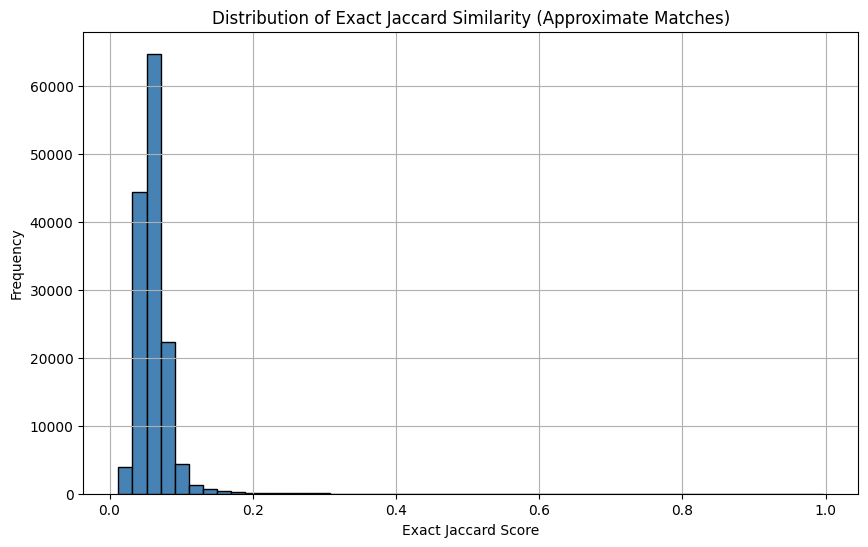

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_eval["exact_jaccard"], bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of Exact Jaccard Similarity (Approximate Matches)")
plt.xlabel("Exact Jaccard Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

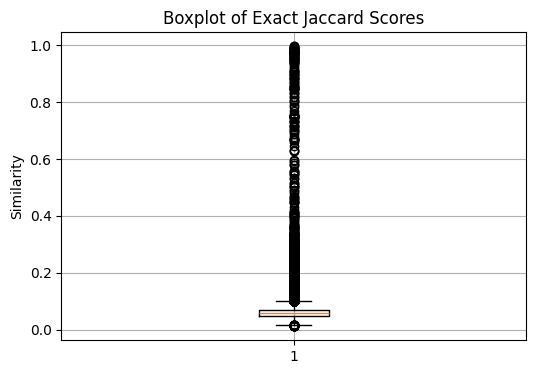

In [33]:
plt.figure(figsize=(6, 4))
plt.boxplot(df_eval["exact_jaccard"])
plt.title("Boxplot of Exact Jaccard Scores")
plt.ylabel("Similarity")
plt.grid(True)
plt.show()

In [34]:
def run_scalability_experiment(ratios, df, num_perm=64, threshold=0.5):
    results = []

    for ratio in ratios:
        print(f"\n🔄 Running for sample ratio: {ratio}")
        sample = df.sample(frac=ratio, random_state=42).copy()

        sample_cleaned = preprocess_reviews(sample)
        print(f"Sample size after cleaning: {len(sample_cleaned)}")

        similar_pairs, duration = find_similar_pairs(sample_cleaned, num_perm, threshold)
        results.append((ratio, len(sample_cleaned), len(similar_pairs), duration))

    return pd.DataFrame(results, columns=["ratio", "rows", "unique_similar_pairs", "time_sec"])

In [35]:
ratios = [0.0075, 0.01] 
scalability_df = run_scalability_experiment(ratios, df)
scalability_df


🔄 Running for sample ratio: 0.0075
Sample size after cleaning: 17532

🔄 Running for sample ratio: 0.01
Sample size after cleaning: 23261


,ratio,rows,unique_similar_pairs,time_sec
0,0.0075,17532,3523,37.99
1,0.0100,23261,6110,49.12
